In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

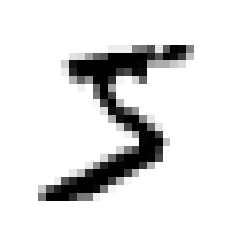

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np 
y= y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train,y_train_5,cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1), dtype = bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5, cv = 3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [12]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv =3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [13]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5,y_pred))
print(recall_score(y_train_5,y_pred))


0.8370879772350012
0.6511713705958311


In [14]:
3530/(3530+687)

0.8370879772350012

In [15]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_pred)

0.7325171197343846

In [16]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [17]:
threshold = 0
y_some_dig_pred = (y_scores > threshold)
y_some_dig_pred

array([ True])

In [18]:
threshold = 8000
y_some_dig_pred = (y_scores > threshold)
y_some_dig_pred

array([False])

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train,y_train_5, cv = 3, method = 'decision_function')

In [20]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

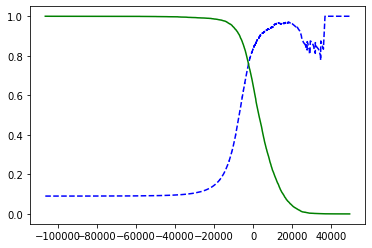

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1],'g-', label = 'recall')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [22]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]

In [23]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5,y_train_pred_90))
print(recall_score(y_train_5,y_train_pred_90))

0.9000345901072293
0.4799852425751706


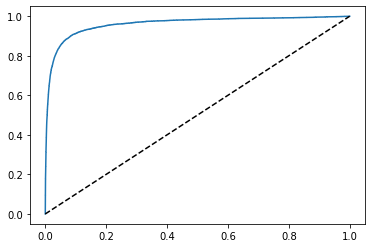

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, label = label)
    plt.plot([0,1],[0,1], 'k--')
    
plot_roc_curve(fpr,tpr)
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

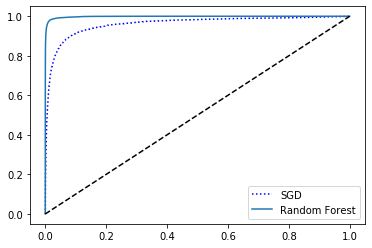

In [26]:
from sklearn.ensemble import RandomForestClassifier
random_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(random_clf,X_train, y_train_5,cv = 3, method='predict_proba')
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr,tpr,'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'lower right')
plt.show()

In [27]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [37]:
random_clf.fit(X_train, y_train_5)
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, cross_val_predict(random_clf,X_train,y_train_5,cv =3)))
print(recall_score(y_train_5, cross_val_predict(random_clf,X_train,y_train_5,cv =3)))

0.9905083315756169
0.8662608374838591


Multi Class Classification

In [38]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [40]:
np.argmaxx(some_digit_scores)

5

In [41]:
svm_clff.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
svm_clf.classes_[5]

5

In [44]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [45]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [46]:
cross_val_score(sgd_clf, X_train,y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train,y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


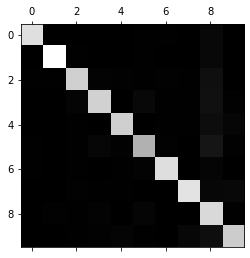

In [32]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [33]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

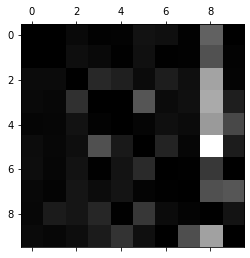

In [34]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

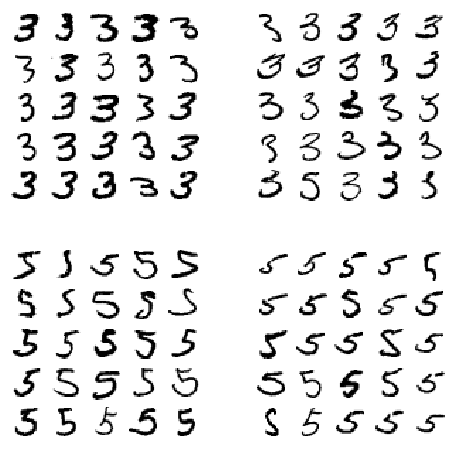

In [57]:
#plot all 3's and 5's

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


In [54]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train>=7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [55]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.976410265560605

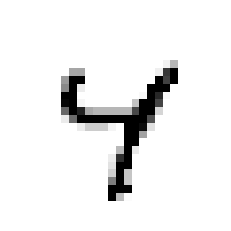

In [58]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[6]])
plot_digits(clean_digit)

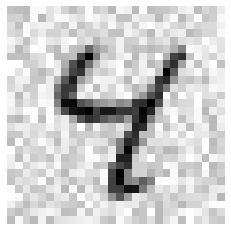

In [59]:
plot_digits([X_test_mod[6]])

Spam Classifier Task